In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import distance

# dir = "/Users/ozgun/Data/Josh/"
dir = "/home/ozgunbabur/Data/Josh/"

data_file = dir + "normalized_mat.tsv"

pca_pre_file = dir + "pca_coords_8.tsv"
pca_file = dir + "pca_8.tsv"

umap_coords = dir + "umap_coords.tsv"
#umap_file = dir + "umap_coords_transposed.tsv"
umap_file = dir + "umap.tsv"
dist_euc_file = dir + "dist_euclidean.tsv"
dist_cos_file = dir + "dist_cosine.tsv"
dist_cos_asis_file = dir + "dist_cosine_asis.tsv"
dist_um_file = dir + "dist_umap.tsv"



In [10]:
def get_similarity_matrix_df(dataF, sigmasq):
    return get_similarity_matrix(dataF.to_numpy(), sigmasq)

# Calculates the similarity matrix based on distances distances
def get_similarity_matrix(m, sigmasq):
    nRow, nCol = m.shape
    sim_mat = np.full((nCol, nCol), 0.0)

    for i in range(0, nCol):
        for j in range(i, nCol):

            # Squared Euclidean distance
            dif = m[:, i] - m[:, j]
            d = np.dot(dif, dif)

            # Cosine distance
            # d = distance.cosine(m[:, i], m[:, j])

            s = np.exp(-d / sigmasq)
            sim_mat[i][j] = s
            sim_mat[j][i] = s

    return sim_mat

# Generates transition probabilities from the similarities
def get_probability_matrix(sim_mat):
    sums = np.sum(sim_mat, axis=1)
    p_mat = (sim_mat.T / sums).T
    return p_mat

# Generates the flows between pairs of cells using transition probabilities
# and the current heat distribution
def get_flow_matrix(p_matrix, heat):
    return (heat * p_matrix.T).T

# Next round of heat distribution is determined by the incoming fow to each cell
def get_next_heat(flow):
    return np.sum(flow, axis=0)

# Generates flow matrices for k rounds of heat distribution.
# Also returns how much heat has arrived at targets on each round (sink_list)
def generate_flow_matrices(p_matrix, source_indicator, target_indicator, k:int):
    flow_list = []
    sink_list = []

    heat = np.zeros(len(source_indicator))
    heat[source_indicator] = 1

    deriv = 1

    while (k < 0 < deriv) or (k > len(flow_list)):
        flow = get_flow_matrix(p_matrix, heat)
        flow_list.append(flow)
        heat = get_next_heat(flow)
        sink_list.append(np.sum(heat[target_indicator]))

        if len(sink_list) > 1:
            deriv = sink_list[-1] - sink_list[-2]

    return flow_list, sink_list

# For the heat has arrived at iteration k, this function generates the list of heat distribution at each step. It also returns a cumulative flow matrix that focuses on the heat that arrived to target.
def generate_weights(flow_matrices, target_indicator, arrive_index:int):
    if arrive_index == -1:
        arrive_index = len(flow_matrices) - 1

    sub_flow = np.zeros(flow_matrices[0].shape)

    cell_size = len(target_indicator)
    weights_mat = np.zeros((arrive_index + 2, cell_size))

    ratios = np.zeros(cell_size)
    ratios[target_indicator] = 1

    inflow_sums = np.sum(flow_matrices[arrive_index], axis = 0)
    weights = inflow_sums * ratios

    weights_mat[arrive_index + 1,:] = weights
    index = arrive_index

    while index >= 0:
        weights = np.matmul(flow_matrices[index], ratios.T)
        sub_flow += flow_matrices[index] * ratios

        outflow_sums = np.sum(flow_matrices[index], axis = 1)
        ratios = weights / outflow_sums
        ratios[np.isnan(ratios)] = 0

        weights_mat[index, :] = weights
        index = index - 1

    return weights_mat, sub_flow

# This is the cumulative version of the above function. It is for the heat that arrived at iteration k or earlier.
def generate_cumulative_weights(flow_matrices, target_indicator, arrive_index):
    if arrive_index < 0:
        arrive_index = len(flow_matrices) - 1

    sub_flow_cum = np.zeros(flow_matrices[0].shape)

    index = arrive_index
    m_list = []
    while index >= 0:
        w, f = generate_weights(flow_matrices, target_indicator, index)
        m_list.append(w)
        sub_flow_cum += f
        index -= 1

    weights = np.zeros(m_list[0].shape)

    for i in range(len(weights)):
        for j in range(min(arrive_index - i + 2, arrive_index + 1)):
            weights[i] += m_list[j][i]

    return weights, sub_flow_cum

# This function is used by the plot animator to update the colors.
def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat

# The plot will use the most intense color for heat value 1. This method determines the total heat on the plot at any time so that the flow can be visualized clearly. Optimal value depends on the specific dataset.
def rescale_weights(weights, total_heat):
    maximum = np.sum(weights[0])
    factor = total_heat / maximum
    return weights * factor

#
def get_sorted_pairs(sub_flow):
    flow_map = {}
    for i in range(len(sub_flow)):
        for j in range(len(sub_flow[i])):
            flow_map[(i, j)] = sub_flow[i, j]

    return sorted(flow_map.items(), key=lambda x:x[1], reverse=True)

# Takes a subset flow and a partial trajectory, completes the trajectory so that
# it starts with src_ind and ends with trg_ind
def build_trajectory(sub_flow, traj, src_ind, trg_ind):

    # Check if the partial trajectory is valid
    if src_ind in traj and traj[0] != src_ind:
        raise Exception("Partial trajectory has the src_index but it not at the start")
    if trg_ind in traj and traj[-1] != trg_ind:
        raise Exception("Partial trajectory has the trg_index but it not at the end")

    candidates = [x for x in range(len(sub_flow)) if x not in traj]

    while traj[0] != src_ind:
        left = traj[0]
        vec = sub_flow[:, left]

        max_ind = -1
        max_val = -1
        for i in candidates:
            if i != left and vec[i] > max_val:
                max_val = vec[i]
                max_ind = i

        traj.insert(0, max_ind)
        candidates.remove(max_ind)

    while traj[-1] != trg_ind:
        right = traj[-1]
        vec = sub_flow[right, :]

        max_ind = -1
        max_val = -1
        for i in candidates:
            if i != right and vec[i] > max_val:
                max_val = vec[i]
                max_ind = i

        traj.append(max_ind)
        candidates.remove(max_ind)

    return traj

def already_part_of_a_trajectory(s, t, trajs):
    for traj in trajs:
        if s in traj:
            ind = traj.index(s)
            if ind != len(traj) - 1 and traj[ind + 1] == t:
                return True
    return False

Probabilities set
flows length = 50


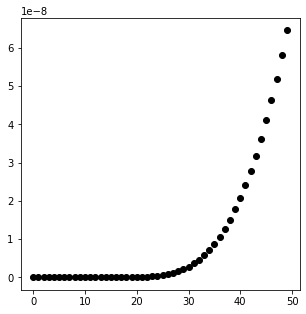

In [3]:
dataF = pd.read_table(umap_file, index_col=0)
# dataF = pd.read_table(pca_file, index_col=0)
cols = dataF.columns.values.tolist()
size = len(cols)

# src_ind = cols.index('tumor_GGGCATCAGTGTACCT-1') #45 tumor
src_ind = cols.index('midpoint_AACACGTTCGGCGCTA-1') #892 luminal
trg_ind = cols.index('midpoint_TGGTTCCTCACTATTC-1') #1 basal
# trg_ind = cols.index('midpoint_AACACGTTCGGCGCTA-1') #892 luminal

source_indicator = np.full(size, False)
source_indicator[src_ind] = True
target_indicator = np.full(size, False)
target_indicator[trg_ind] = True

sim = get_similarity_matrix_df(dataF, sigmasq=1)
p_mat = get_probability_matrix(sim)
p_mat[target_indicator,:] = 0

print("Probabilities set")

heat = np.zeros(size)
heat[source_indicator] = 1

flows, sinks = generate_flow_matrices(p_mat, source_indicator, target_indicator, 50)

print("flows length = " + str(len(flows)))

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(np.array(range(len(sinks))), sinks, color = 'k')
plt.show()

In [5]:

weights, sub_flow = generate_cumulative_weights(flows, target_indicator, -1)

/tmp/ipykernel_1821263/100993974.py:82: RuntimeWarning: invalid value encountered in true_divide
  ratios = weights / outflow_sums


In [8]:
# a = np.max(weights, axis=1)
# ww, ff = generate_cumulative_weights(flows, target_indicator, 3)
# print(ww[:, target_indicator])
print(weights[:, target_indicator])


[[0.00000000e+00]
 [9.70261311e-49]
 [3.58426796e-23]
 [2.39597743e-15]
 [1.70521340e-11]
 [3.02319431e-10]
 [2.18036207e-09]
 [8.98785274e-09]
 [2.68873126e-08]
 [6.93755408e-08]
 [1.81940107e-07]
 [5.73330394e-07]
 [2.19923773e-06]
 [8.72798079e-06]
 [3.16378948e-05]
 [1.00822805e-04]
 [2.82982488e-04]
 [7.09024788e-04]
 [1.60997191e-03]
 [3.35903089e-03]
 [6.51613176e-03]
 [1.18706801e-02]
 [2.04785322e-02]
 [3.36900766e-02]
 [5.31675025e-02]
 [8.08905735e-02]
 [1.19151306e-01]
 [1.70538767e-01]
 [2.37915704e-01]
 [3.24388994e-01]
 [4.33275866e-01]
 [5.68067757e-01]
 [7.32393398e-01]
 [9.29982444e-01]
 [1.16463068e+00]
 [1.44016752e+00]
 [1.76042633e+00]
 [2.12921782e+00]
 [2.55030666e+00]
 [3.02739123e+00]
 [3.56408649e+00]
 [4.16390975e+00]
 [4.83026900e+00]
 [5.56645382e+00]
 [6.37562832e+00]
 [7.26082607e+00]
 [8.22494664e+00]
 [9.27075365e+00]
 [1.04008740e+01]
 [1.16177981e+01]
 [1.29238810e+01]]


In [11]:

weights = rescale_weights(weights)
print("weights = \n" + str(weights))

weights = 
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.24306621e-032 3.54743340e-049 6.35987570e-012 ... 3.32080154e-095
  5.97262530e-116 4.32986618e-120]
 [1.99194828e-018 2.81319624e-023 4.79768480e-005 ... 5.41318447e-054
  1.61368830e-066 1.44136471e-062]
 ...
 [8.01890422e-002 6.22474650e-001 7.65797205e-015 ... 9.08424130e-050
  8.32967233e-055 8.18231184e-043]
 [1.15068048e-002 4.16480570e-001 4.98623492e-030 ... 2.48510012e-097
  6.67998798e-106 9.80901250e-079]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


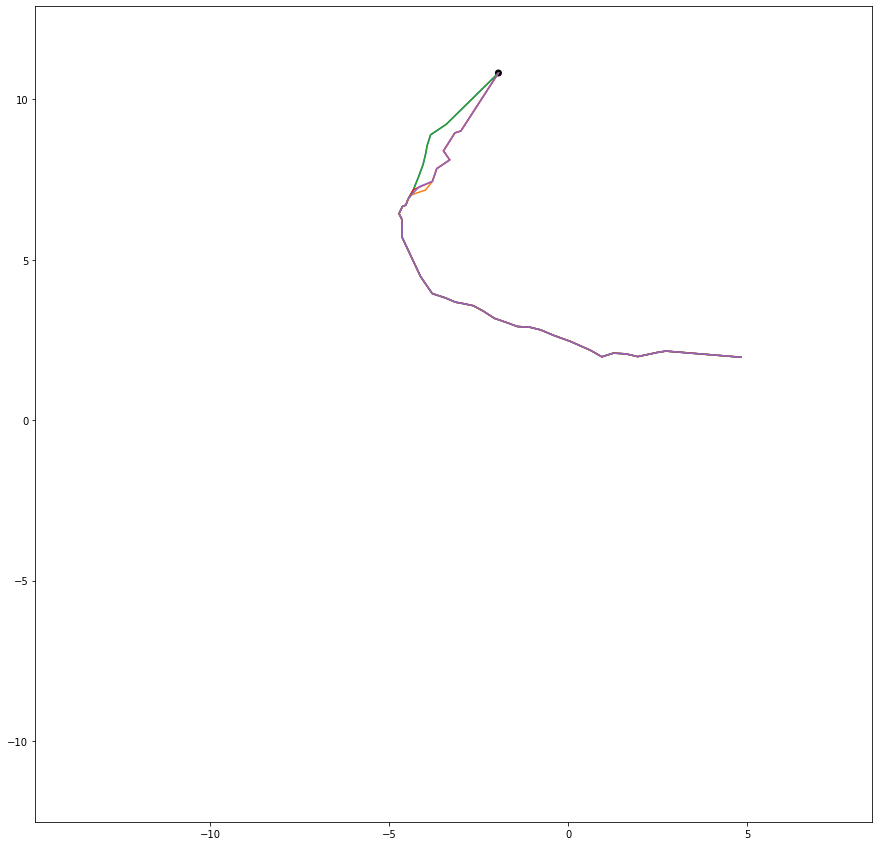

In [12]:

# generate 10 distinct trajectories that has the maximal pairs
pairs = get_sorted_pairs(sub_flow)
trajs = []
i = 0
while len(trajs) < 5:
    s = pairs[i][0][0]
    t = pairs[i][0][1]

    if not already_part_of_a_trajectory(s, t, trajs):
        traj = [s, t]
        traj = build_trajectory(sub_flow, traj, src_ind, trg_ind)
        trajs.append(traj)
    i += 1

# Calculate ranks based on maximum weights
maxes = np.max(weights, axis=0)
ranks = maxes.argsort().argsort()

table = pd.read_table(umap_file, index_col=0)
mat = table.to_numpy()

paths = []
for i in range(len(trajs)):
    path = mat[:, trajs[i]]
    paths.append(path)

# Order dots so that darker ones painted later
colors = np.zeros((len(weights), len(weights[0])))
pos = np.zeros(mat.shape)
for i in range(len(ranks)):
    pos[:, ranks[i]] = mat[:, i]
    for j in range(len(weights)):
        colors[j][ranks[i]] = weights[j][i]

initial_colors = np.zeros(colors[0].shape)
initial_colors[0] = 1

fig = plt.figure(figsize=(15, 15))
scat = plt.scatter(pos[0], pos[1], c = initial_colors, cmap='Greys', alpha=1)

for i in range(len(paths)):
    plt.plot(paths[i][0], paths[i][1])

ani = animation.FuncAnimation(fig, update_plot, frames=len(colors), fargs=(colors, scat))
ani.save('scatter.gif', writer='pillow')


In [14]:
print(len(trajs))

5


In [182]:
size = 4
data = np.array([range(size), range(size)])
print(data)
sim = get_similarity_matrix(data)
print(sim)

source_indicator = np.full(size, False)
source_indicator[0] = True
target_indicator = np.full(size, False)
target_indicator[size-1] = True

p = get_probability_matrix(sim)
p[target_indicator,:] = 0
print('p=\n' + str(p))

flows, sinks = generate_flow_matrices(p, source_indicator, target_indicator, 10)

print("flows length = " + str(len(flows)))

weights = generate_weights(flows, target_indicator, -1)
print("weights = \n" + str(weights))
cum_w = np.sum(weights, axis=0)

print("cum_w = \n" + str(cum_w))

[[0 1 2 3]
 [0 1 2 3]]
[[1.00000000e+00 1.35335283e-01 3.35462628e-04 1.52299797e-08]
 [1.35335283e-01 1.00000000e+00 1.35335283e-01 3.35462628e-04]
 [3.35462628e-04 1.35335283e-01 1.00000000e+00 1.35335283e-01]
 [1.52299797e-08 3.35462628e-04 1.35335283e-01 1.00000000e+00]]
p=
[[8.80536890e-01 1.19167709e-01 2.95387219e-04 1.34105590e-08]
 [1.06478868e-01 7.86778329e-01 1.06478868e-01 2.63934726e-04]
 [2.63934726e-04 1.06478868e-01 7.86778329e-01 1.06478868e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
flows length = 10
weights = 
[[1.38080672e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.11504264e-02 2.65038777e-03 7.25302004e-06 0.00000000e+00]
 [8.87891118e-03 4.55875744e-03 3.70398570e-04 0.00000000e+00]
 [6.87228826e-03 5.90225863e-03 1.03352030e-03 0.00000000e+00]
 [5.05970411e-03 6.76412105e-03 1.98424203e-03 0.00000000e+00]
 [3.41541084e-03 7.14295024e-03 3.24970611e-03 0.00000000e+00]
 [1.96152068e-03 6.94764143e-03 4.89890508e-03 0.00000000e+00

/tmp/ipykernel_1299923/636077474.py:79: RuntimeWarning: invalid value encountered in true_divide
  ratios = weights / outflow_sums
